In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import bayes_opt as BayesianOptimization 
import scipy as sp 
import ansys.mapdl.core as asys
import pandas as pd

In [2]:
asys.close_all_local_instances()

In [3]:
## FUnctions give Yeoh Coefficients based on shore continuum study. 
def s_c1(s):
    return 4.905e20*np.exp(-2.256*s) + 2.893e6*np.exp(-0.04024*s)

def s_c2(s):
    return -5.529e8*np.exp(-0.4783*s) + 384.7*np.exp(0.0967*s)

def s_c3(s):
    return 18.3*s**2 - 1744*s + 4.234e4

PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...
Product:             Ansys Mechanical Enterprise Academic Student
MAPDL Version:       23.1
ansys.mapdl Version: 0.64.1

Product:             Ansys Mechanical Enterprise Academic Student
MAPDL Version:       23.1
ansys.mapdl Version: 0.64.1



c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


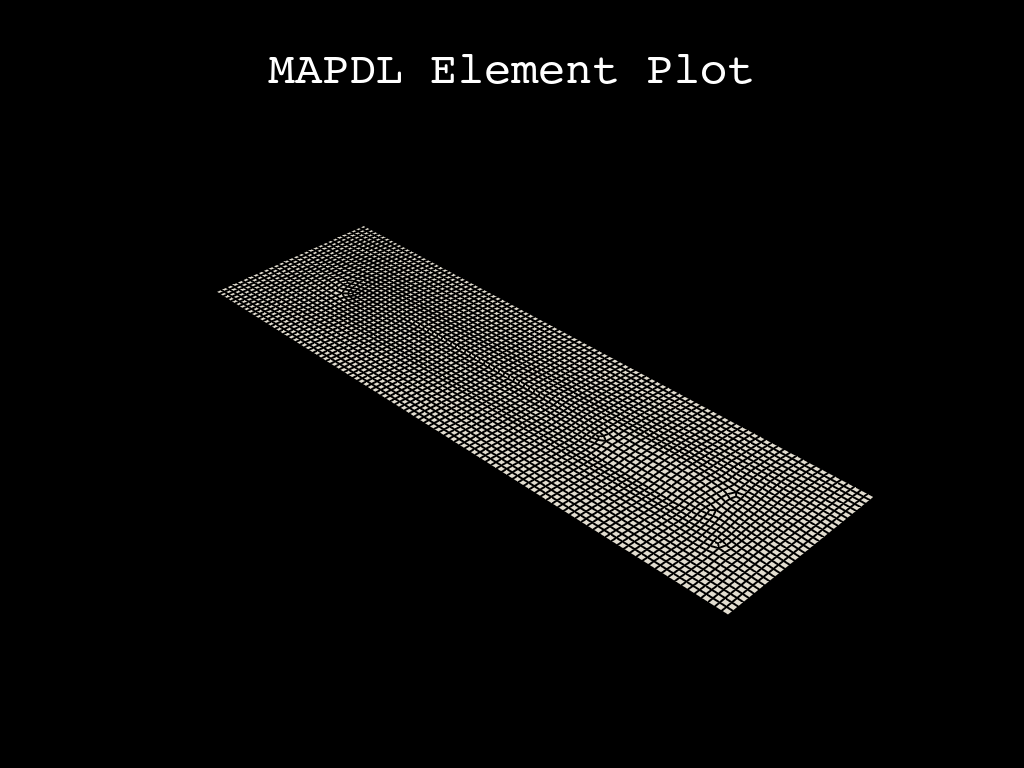

Exception in thread Threaded `close_mapdl` function:
Traceback (most recent call last):
  File "c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Threaded `close_mapdl` function:
Traceback (most recent call last):
  File "c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Threaded `close_mapdl` function:
Traceback (most recent call last):
  File "c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self.run()
  File "c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self.run()
  File "c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c

*****  MAPDL SOLVE    COMMAND  *****

 *** NOTE ***                            CP =       0.281   TIME= 11:31:09
 There is no title defined for this analysis.                            

 *** SELECTION OF ELEMENT TECHNOLOGIES FOR APPLICABLE ELEMENTS ***
                ---GIVE SUGGESTIONS ONLY---

 ELEMENT TYPE  1 IS PLANE182 WITH PLANE STRESS OPTION. KEYOPT(1) IS ALREADY
 SET AS SUGGESTED.



 *** MAPDL - ENGINEERING ANALYSIS SYSTEM  RELEASE 2023 R1          23.1     ***
 Ansys Mechanical Enterprise Academic Student      
 01055371  VERSION=WINDOWS x64   11:31:09  JUN 27, 2023 CP=      0.281

                                                                               



                       S O L U T I O N   O P T I O N S

   PROBLEM DIMENSIONALITY. . . . . . . . . . . . .2-D                  
   DEGREES OF FREEDOM. . . . . . UX   UY  
   ANALYSIS TYPE . . . . . . . . . . . . . . . . .STATIC (STEADY-STATE)
   NONLINEAR GEOMETRIC EFFECTS . . . . . . . . . .ON
   NEWTON-RAPHSON O

c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


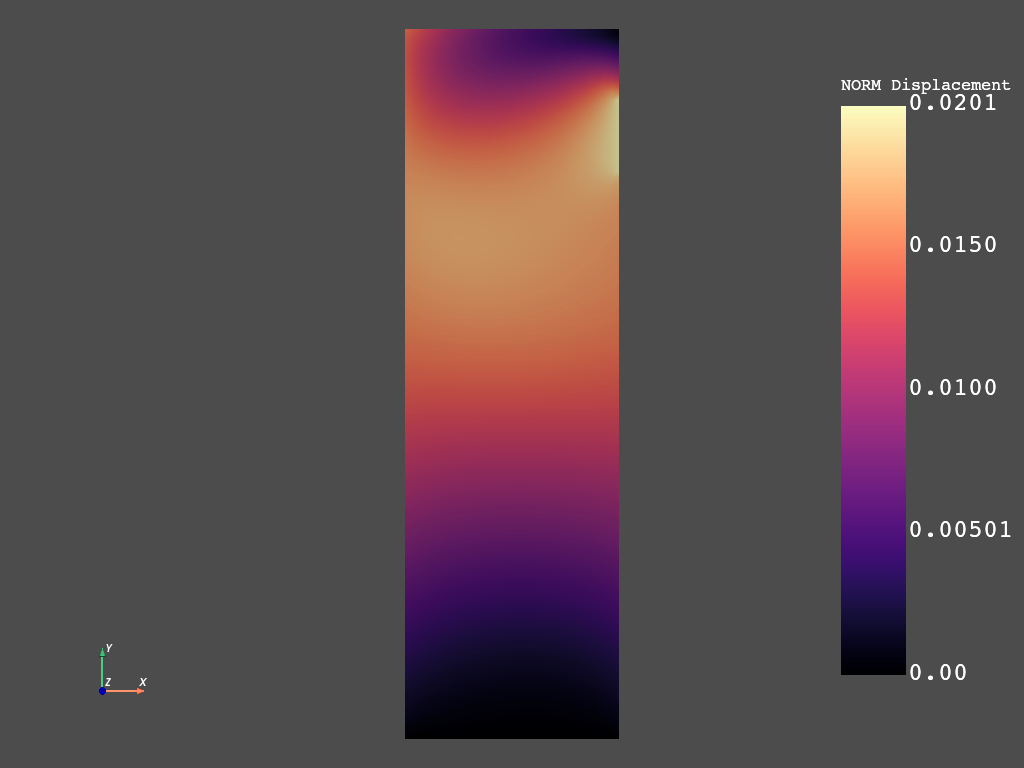

c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


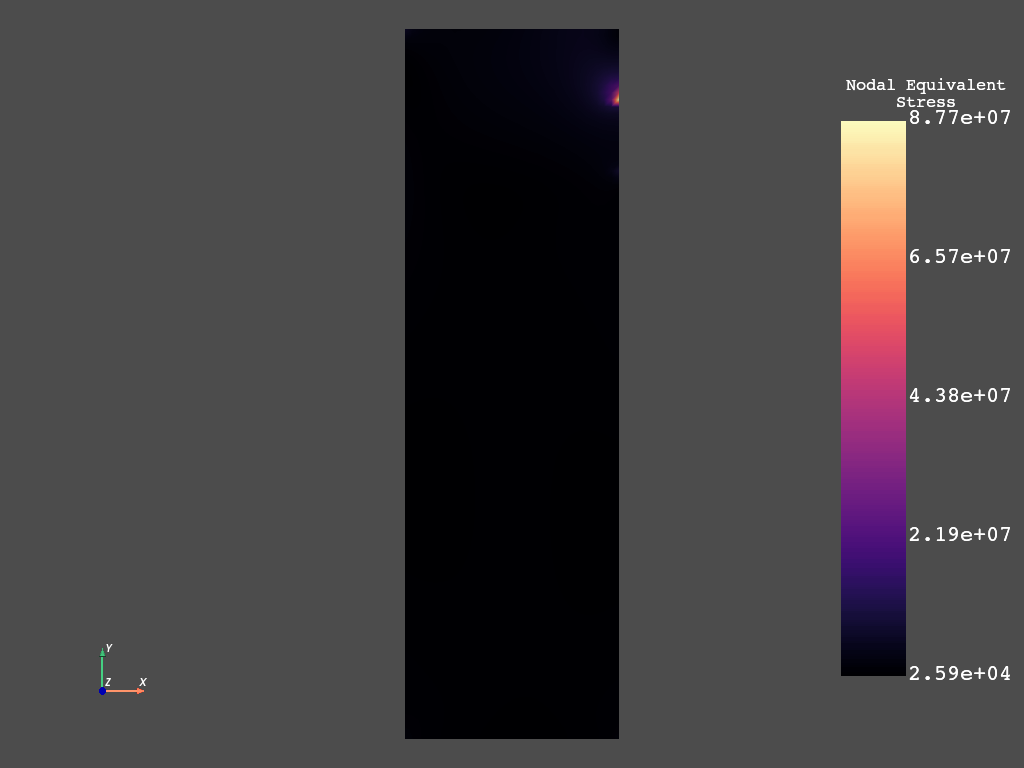

c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


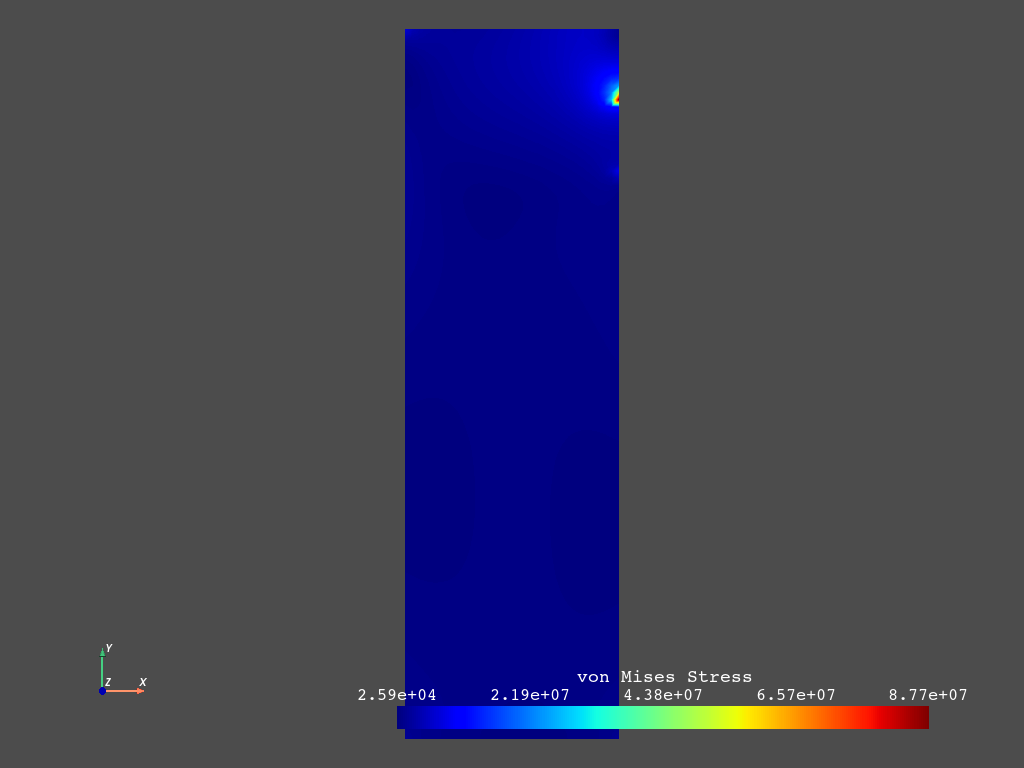

ValueError: could not convert string to float: *** NOTE ***                            CP =       9.484   TIME= 11:31:24
 Summations based on final geometry and will not agree with solution     
 reactions.                                                              

 ***** SUMMATION OF TOTAL    FORCES AND MOMENTS IN THE GLOBAL COORDINATE SYSTEM *****
  FX  =  0.1336709E-12
  FY  =  0.7993606E-13
  FZ  =   0.000000    
  MX  =   0.000000    
  MY  =   0.000000    
  MZ  = -0.4409906E-14

 SUMMATION POINT=  0.0000      0.0000      0.0000

In [4]:
see = asys.launch_mapdl() # launch local instance
see.mute
see.clear()
see.prep7() # Enter prep
print(see)

##------------------------------------------------------------------------------------------------------
## INIT
ii = 0
sim_res = 20
RF = np.zeros((sim_res,1))
Energy = np.zeros((sim_res,1))
value_last = 0
esize = np.logspace(0.014, 0, 20)
iii = 0
disp = 0.02
change = 1
# while change > 0.1: # Mesh converge
print(see)
see.units("SI")


coeff = 30 # Shore hardness in use

# radius = np.array([0.020,0.020,0.040,0.030])

## ELEMENT
## Define Element Type
# define a PLANE183 element type with thickness
see.et(1, "PLANE182", kop3=3)
see.r(1, 0.01)  # thickness of 0.01 meters (10CM)

##------------------------------------------------------------------------------------------------------
## MATERIAL 
# TBDE,HYPE,1,,,  
# TB,HYPE,1,1,2,YEOH  
# TBTEMP,0
# TBDATA,,33,44,55,,, 

see.tb("HYPER",1,1,3,"YEOH") # Second input is material ID. Need to loop over this for each material
see.tbtemp(20)

# calculate coefficients from shore hardness and apply to model
C1 = s_c1(coeff)   
C2 = s_c2(coeff)   
C3 = s_c3(coeff)     
see.tbdata(1,C1,C2,C3,0,0,0)
see.nlgeom("ON")

##------------------------------------------------------------------------------------------------------
## GEOMETRY
top = 0.020
length = 0.100
z = "0" # 2D
l = 0.1
per = 1.0
w1 = 0.030
w2 = per*w1
l1 = 0.02
l2 = l - l1
n = 6
pointsx = [(w1-w2)/2, ((w1-w2)/2)+w2, w1, w1, 0, 0]
pointsy = [0 , 0, l2, l, l, l2] 

# KEYPOINT GEN
# Top down one side 
j=1
for i in range(0,n): # for each block
    # print(i)
    # print(j)
    see.k(str(j), str(pointsx[i]), str(pointsy[i]), z)
    j += 1 
    # generate a point r/2 from centre line. 
    all_k = np.linspace(1,n,n)
# see.kplot(
#     show_keypoint_numbering=True,
#     background="black",
#     show_bounds=True,
#     font_size=26,
# )


# Generate Area
see.a(*all_k)

##------------------------------------------------------------------------------------------------------
## MESH
    
# Define mesh controls
# Define mesh controls and generate mesh
elem_size = 0.001 # \\/ variable in function
see.esize(elem_size) # esize[iii])
see.amesh("all")
see.eplot(vtk=True, show_edges=True, show_axes=False, line_width=2, background="k")

##------------------------------------------------------------------------------------------------------
## Boundary Conditions

# Fixed bottom with top loaded
# Create components for defining loads and constraints

see.nsel("S", "LOC", "Y", 0)     # Select nodes on bottom edge
see.cm("Y_FIXED", "NODES")       # Create nodal component
see.d("ALL", "UX")
see.d("ALL", "UY")


see.nsel("S", "LOC", "Y", l) # grab top nodes
see.cm("MOVE", "NODES")       # give it a name
see.d("ALL", "UX")


## Grab left and right sides and displace accordingly. 
see.nsel("S","LOC", "X", 0)
see.nsel("R","LOC", "Y",l2,l-0.01)
see.cm("LEFT_PULL", "NODES")


see.nsel("S","LOC","X",w1)
see.nsel("R","LOC", "Y",l2,l-0.01)
see.cm("RIGHT_PULL","NODES")#


##------------------------------------------------------------------------------------------------------
## Solution
see.slashsolu()  # Enter solution
see.antype("STATIC", "NEW")  # Specify a new static analysis (Optional)
see.nsubst(200,0,0)
# see.d("Y_FIXED", "UY", 0)        # Fix the selected nodes in Y direction
# see.d("Y_FIXED", "UX", 0)        # Fix the selected nodes in X direction
## Iterate over a top displacement adn record resultsfor i = 0.25:
#test = 0.01 # 10mm displacement will be changed in func
# see.d("MOVE", "UX", 0)
see.d("MOVE", "UY", -0.1) # yank it up by func input \\/ variable


see.d("LEFT_PULL", "UX",-disp)
see.d("RIGHT_PULL", "UX",disp)

# Solve the model
see.allsel(mute=True)

output = see.solve()
print(output)
see.finish()

##------------------------------------------------------------------------------------------------------
## Post-processor


see.post1()
# see.set(1, 1)

see.post_processing.plot_nodal_displacement(
    "NORM",
    cpos="xy",
    cmap="magma",
)

see.post_processing.plot_nodal_eqv_stress(cpos="xy", cmap="magma")
result = see.result
result.plot_principal_nodal_stress(
    0,
    "SEQV",
    lighting=False,
    cpos="xy",
    background="w",
    text_color="k",
    add_text=False,
)
see.prenergy("SENE")

# Mesh Convergence
# if the value doesn't cahnge by more than set percentage
# value = see.fsum("Y_FIXED")
# value = see.post_processing.()
# print(type(value))
# if value_last != 0:
#     change = (value - value_last)/value_last
#     if change < 0.1: # Currently 10% converge
#         break
#     else:
#         continue
# value_last = value
# # Reaction Forces
# iii += 1
    
RF[ii] = see.fsum("Y_FIXED")
Energy[ii] = see.prenergy("ALL")

In [ ]:
grid = see.mesh.grid
grid



UnstructuredGrid (0x226c7fa7c40)
  N Cells:    3200
  N Points:   9861
  X Bounds:   0.000e+00, 3.000e-02
  Y Bounds:   0.000e+00, 1.000e-01
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   10

In [ ]:
coeff = 40

print(s_c1(coeff),s_c2(coeff) ,s_c3(coeff) )


578506.2237345591 18403.871198735964 1860.0
